c:\Users\kimsi\anaconda3\envs\omnizart_simple\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kimsi\anaconda3\envs\omnizart_simple\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kimsi\anaconda3\envs\omnizart_simple\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52488 (\N{HANGUL SYLLABLE CO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kimsi\anaconda3\envs\omnizart_simple\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51652 (\N{HANGUL SYLLABLE JIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\kimsi\anaconda3\envs\omnizart_simple\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 54253 (\N{HANGUL SYLLAB

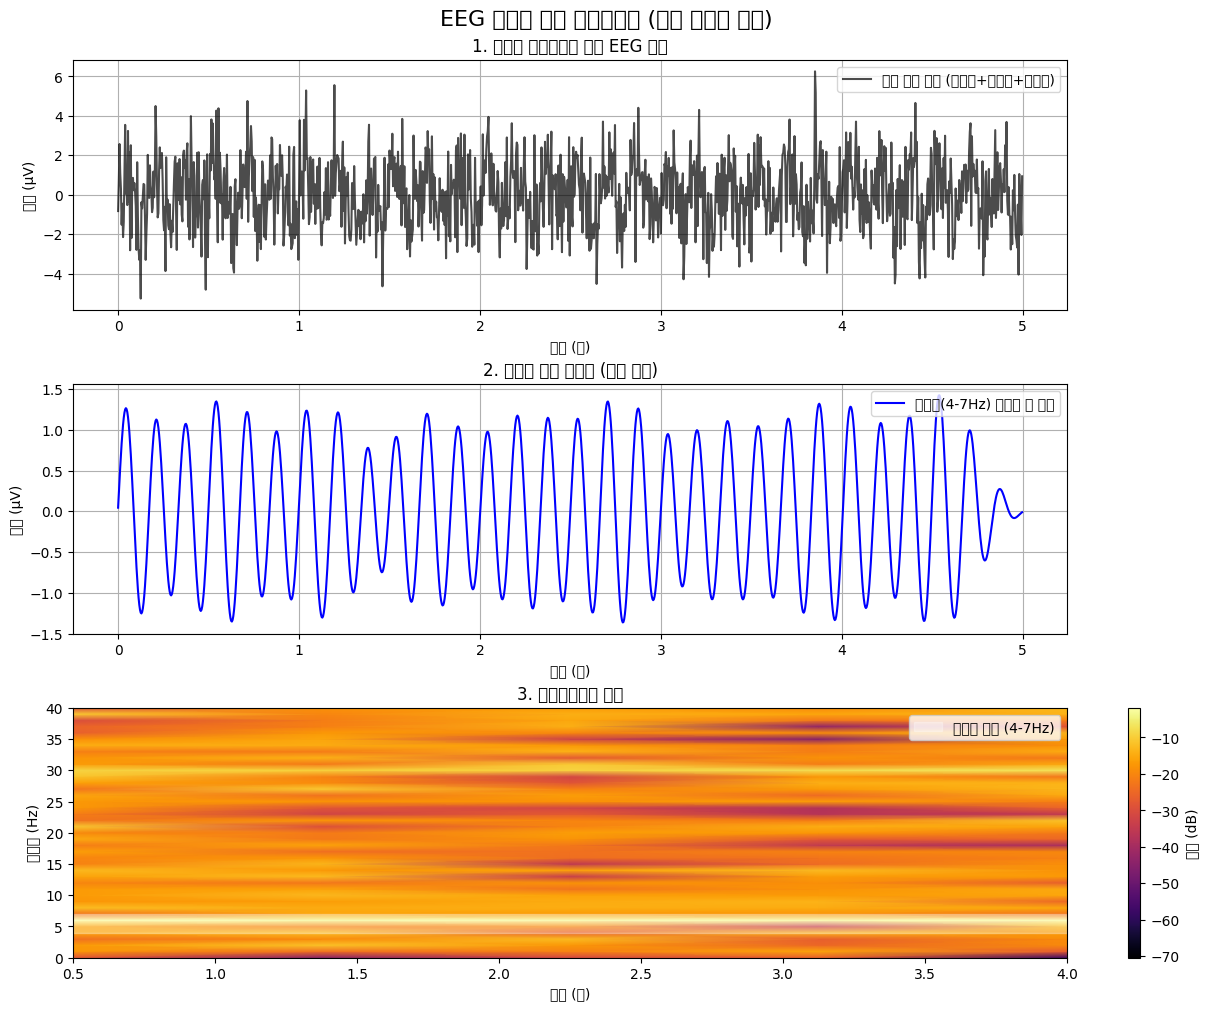

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, spectrogram

# --- 1. 가상 EEG 데이터 생성 ---
# 실제 데이터가 없으므로, 여러 주파수와 노이즈가 섞인 가상 신호를 생성합니다.
# 이력서에 언급된 '세타파(4-7Hz)'가 포함되도록 6Hz 신호를 중심으로 만듭니다.

SAMPLING_RATE = 256  # 샘플링 주파수 (Hz), 일반적인 EEG 장비 스펙
DURATION = 5        # 데이터 길이 (초)
N_SAMPLES = SAMPLING_RATE * DURATION

# 시간 축 생성
time = np.linspace(0, DURATION, N_SAMPLES, endpoint=False)

# 6Hz 세타파(핵심 신호) + 30Hz 감마파(기타 뇌파) + 노이즈
theta_wave = 1.0 * np.sin(2 * np.pi * 6 * time)
gamma_wave = 0.5 * np.sin(2 * np.pi * 30 * time)
noise = 1.5 * np.random.randn(N_SAMPLES)

# 가상 EEG 신호
# Window Slicing
virtual_eeg_signal = theta_wave + gamma_wave + noise


# --- 2. 세타파(4-7Hz) 대역 필터링 (피처 추출 과정) ---

THETA_LOW = 4   # 세타파 최저 주파수
THETA_HIGH = 7  # 세타파 최고 주파수

def bandpass_filter(data, lowcut, highcut, fs, order=5):
    """주어진 데이터에 대해 밴드패스 필터를 적용하는 함수"""
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

# 가상 EEG 신호에서 세타파 대역만 필터링하여 추출
theta_filtered_signal = bandpass_filter(virtual_eeg_signal, THETA_LOW, THETA_HIGH, SAMPLING_RATE)


# --- 3. 스펙트로그램 생성 ---
# 시간-주파수 분석을 통해 신호의 특성을 시각화합니다.

frequencies, times, Sxx = spectrogram(virtual_eeg_signal, SAMPLING_RATE, nperseg=SAMPLING_RATE) # 1초 단위로 분석


# --- 4. 결과 시각화 ---
# 전체 과정을 한눈에 볼 수 있도록 그래프로 출력합니다.

fig, axs = plt.subplots(3, 1, figsize=(12, 10), constrained_layout=True)
fig.suptitle("EEG 전처리 과정 프로토타입 (가상 데이터 기반)", fontsize=16)

# Plot 1: 원본 가상 EEG 신호
axs[0].plot(time, virtual_eeg_signal, label="원본 가상 신호 (세타파+감마파+노이즈)", color='black', alpha=0.7)
axs[0].set_title("1. 윈도우 슬라이싱된 가상 EEG 신호")
axs[0].set_xlabel("시간 (초)")
axs[0].set_ylabel("진폭 (μV)")
axs[0].grid(True)
axs[0].legend()

# Plot 2: 세타파 필터링 후 신호
axs[1].plot(time, theta_filtered_signal, label="세타파(4-7Hz) 필터링 후 신호", color='blue')
axs[1].set_title("2. 세타파 대역 필터링 (피처 추출)")
axs[1].set_xlabel("시간 (초)")
axs[1].set_ylabel("진폭 (μV)")
axs[1].grid(True)
axs[1].legend()

# Plot 3: 스펙트로그램
pcm = axs[2].pcolormesh(times, frequencies, 10 * np.log10(Sxx), shading='gouraud', cmap='inferno')
axs[2].set_title("3. 스펙트로그램 생성")
axs[2].set_xlabel("시간 (초)")
axs[2].set_ylabel("주파수 (Hz)")
axs[2].set_ylim(0, 40)  # 관심 있는 주파수 대역(40Hz 이하)만 표시
fig.colorbar(pcm, ax=axs[2], label="강도 (dB)")

# 스펙트로그램에 세타파 대역 강조 표시
axs[2].axhspan(THETA_LOW, THETA_HIGH, color='white', alpha=0.3, label='세타파 대역 (4-7Hz)')
axs[2].legend()

plt.show()